# Assignment 9 Part A: Unsupervised Clustering

## Discussion and preprocessing plan
A high sparsity exists, with ~0.5% of all transactions being fraud transactions.

#### Time
Going to need to convert date to seperate year-month-weekday columns. Will drop "unix_time" column since it contains highly duplicate data as the transaction date and time column. Granularity of time of day could be explored, but for now a simple day-month-year will be the first plan of attack.

#### Customer Information

Customer first and last name can be dropped in favor of the cc_num column. Customer's date of birth will be converted to simply how many years old they are. Their employment will be kept due to this providing valuable information of potential fraud transactions. The sex field is potentially ommitable, so if increased model performance is required removing sex will be among the first strategies. CC_num is a database index and does not provide true value to the analysis, therefore it will be dropped as well.

**EDIT**
After some experimentation, I found customer CC number to not be ordinal and creating categorically encoding it is unfeasible. I believe the name to be valuable and which customer it is coming from, but worried it will introduce too much sparsity when encoded. Future models could incorporate these data points by introducing some form of dimensionality reduction.

#### Merchant information
Merchant and category of purchase will need to be one-hot encoded. The amount of the transaction is valuable and will be scaled via normalization. Transaction number can be dropped as well since it is not providing any additional value.


#### Geographic Information

Lat-Lon combinations of both merchant and customer will not be used since not much valuable insight was obtained during data exploration. Customer street will also be dropped in favor of the city and city information as geographic information for the customer since I suspect it is too high detail and will be represented to some degree by the city column. Zip will also be dropped in favor of city and state.


City population will be kept also. This could potentially have duplicate information stored in it since city itself is also a field. These two fields might be worth looking into further for processing.


## Encoding Scheme

Year and month will naturally be ordinally encoded. Week day however should be one-hot encoded since it is categorical over ordinal. Employment, merchant, and category will be one-hot encoded. The remainder of the numerical fields will be scaled using standardization.

**EDIT**
 After experimenting, I found out that one-hot encoding every categorical field eats too much RAM. I decided on one-hot encoding state and employment. This was because state will capture geographical information while employment captures information about the person. City and category were dropped due to hardware limitations.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import PrecisionRecallDisplay

In [5]:
fraud_dataset = pd.read_csv("transactions.csv")

### Drop Unwanted Columns

### Seperate year-month-weekday and delete "trans_date_trans_time"

In [6]:
date_format = '%Y-%m-%d %H:%M:%S'
year_column = [datetime.strptime(row_date, date_format).year for row_date in fraud_dataset.trans_date_trans_time]
month_column = [datetime.strptime(row_date, date_format).month for row_date in fraud_dataset.trans_date_trans_time]
weekday_column = [(datetime.strptime(row_date, date_format).toordinal()%7 + 1) for row_date in fraud_dataset.trans_date_trans_time]

input_data = {"year": year_column,
              "month": month_column,
              "weekday": weekday_column}

time_encoded_df = pd.DataFrame(data=input_data)

del year_column
del month_column
del weekday_column

### Encoding Processing

In [7]:
# Encode Weekday Data
weekday_encoder = OneHotEncoder()
weekday_encoder.fit(time_encoded_df["weekday"].to_numpy().reshape(-1, 1))
weekday_encoded_values = weekday_encoder.fit_transform(time_encoded_df[['weekday']]).toarray()

weekday_encoded_df = pd.DataFrame(weekday_encoded_values, columns=weekday_encoder.get_feature_names_out())
weekday_encoded_df.head()

del weekday_encoded_values

In [8]:
time_encoded_df = pd.concat([time_encoded_df, weekday_encoded_df], axis=1)
time_encoded_df = time_encoded_df.drop(["weekday"], axis=1)
time_encoded_df.head()

,year,month,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,2019,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2019,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2019,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2019,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2019,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# Encode Merchant
# merch_encoder = OneHotEncoder()
# merch_encoder.fit(fraud_dataset_copy["merchant"].to_numpy().reshape(-1, 1))
# encoded_merch_values = merch_encoder.fit_transform(fraud_dataset_copy[['merchant']]).toarray()

# merch_encoded_df = pd.DataFrame(encoded_merch_values, columns=merch_encoder.get_feature_names())
# merch_encoded_df.head()
# print(len(merch_encoded_df.columns))

In [10]:
# Encode Category
# category_encoder = OneHotEncoder()
# category_encoder.fit(fraud_dataset_copy["merchant"].to_numpy().reshape(-1, 1))
# encoded_category_values = category_encoder.fit_transform(fraud_dataset_copy[['merchant']]).toarray()

# category_encoded_df = pd.DataFrame(encoded_category_values, columns=category_encoder.get_feature_names())
# category_encoded_df.head()
# print(len(category_encoded_df.columns))

In [11]:
# Encode sex
sex_encoder = OneHotEncoder()
sex_encoder.fit(fraud_dataset["sex"].to_numpy().reshape(-1, 1))
encoded_sex_values = sex_encoder.fit_transform(fraud_dataset[['sex']]).toarray()

sex_encoded_df = pd.DataFrame(encoded_sex_values, columns=sex_encoder.get_feature_names_out())
sex_encoded_df.head()
print(len(sex_encoded_df.columns))

del encoded_sex_values


2


In [12]:
# Encode state
state_encoder = OneHotEncoder()
state_encoder.fit(fraud_dataset["state"].to_numpy().reshape(-1, 1))
encoded_state_values = state_encoder.fit_transform(fraud_dataset[['state']]).toarray()

state_encoded_df = pd.DataFrame(encoded_state_values, columns=state_encoder.get_feature_names_out())
state_encoded_df.head()

del encoded_state_values

In [13]:
# Encode city
# city_encoder = OneHotEncoder()
# city_encoder.fit(fraud_dataset_copy["city"].to_numpy().reshape(-1, 1))
# encoded_city_values = city_encoder.fit_transform(fraud_dataset_copy[['city']]).toarray()

# city_encoded_df = pd.DataFrame(encoded_city_values, columns=city_encoder.get_feature_names())
# city_encoded_df.head()

In [14]:
# Encode Employment
employment_encoder = OneHotEncoder()
employment_encoder.fit(fraud_dataset["job"].to_numpy().reshape(-1, 1))
encoded_employment_values = employment_encoder.fit_transform(fraud_dataset[['job']]).toarray()

job_encoded_df = pd.DataFrame(encoded_employment_values, columns=employment_encoder.get_feature_names_out())
job_encoded_df.head()

del encoded_employment_values

In [15]:
# print(len(employment_encoder.get_feature_names()))

In [16]:
# encoded_employment_df = pd.DataFrame(encoded_employment_values, columns=employment_encoder.get_feature_names())
# encoded_employment_df.head()

### Recreate 

In [17]:
drop_columns = ["Unnamed: 0", "cc_num", "trans_date_trans_time"]
fraud_dataset.drop(drop_columns, axis=1, inplace=True)
fraud_dataset.head()

,merchant,category,amt,first,last,sex,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [18]:
drop_columns = ["first", "last", "zip", "lat", "long", "merch_lat", "merch_long", "trans_num", "unix_time", "street"]
fraud_dataset.drop(drop_columns, axis=1, inplace=True)

In [19]:
# Drop modified columns from dataset
fraud_dataset = fraud_dataset.drop(["category", "sex", "merchant", "state", "city", "job", "dob"], axis=1)

In [20]:
total_df = pd.concat([time_encoded_df, fraud_dataset], axis=1)
total_df.head()

del time_encoded_df
del fraud_dataset

In [21]:
pd.concat([total_df, sex_encoded_df], axis=1)
total_df.head()

del sex_encoded_df

In [22]:
total_df = pd.concat([total_df, state_encoded_df], axis=1)
total_df.head()
del state_encoded_df

In [23]:
total_df = pd.concat([total_df, job_encoded_df], axis=1)
del job_encoded_df

In [24]:
# Splitting the dataset into the Training set and Test set - use trian_test_split
y = total_df["is_fraud"]
x = total_df.drop(["is_fraud"], axis=1)

test__perc = .20      # 20% for test split
feature_train, feature_test, label_train, label_test = train_test_split(x, y, test_size= test__perc)

### Numerical Processing

In [25]:
# Feature Scaling - required due to different orders of magnitude across the features
# make sure to save the scaler for future use in inference

feature_info = {}
feature_year_info = {}
feature_month_info = {}
feature_amt_info = {}
feature_pop_info = {}

In [26]:
feature_year_info["mean"] = feature_train["year"].mean()
feature_year_info["std"] = feature_train["year"].std()
feature_info["year"] = feature_year_info

In [27]:
feature_month_info["mean"] = feature_train["month"].mean()
feature_month_info["std"] = feature_train["month"].std()
feature_info["month"] = feature_month_info

In [28]:
feature_amt_info["mean"] = feature_train["amt"].mean()
feature_amt_info["std"] = feature_train["amt"].std()
feature_info["amt"] = feature_amt_info

In [29]:
feature_pop_info["mean"] = feature_train["city_pop"].mean()
feature_pop_info["std"] = feature_train["city_pop"].std()
feature_info["city_pop"] = feature_pop_info

In [30]:
# scale feature train inputs
feature_train.loc[:, "year_scaled"] = (feature_train["year"]-feature_year_info["mean"])/feature_year_info["std"] 
feature_train.loc[:, "month_scaled"] = (feature_train["month"]-feature_month_info["mean"])/feature_month_info["std"]
feature_train.loc[:, "amt_scaled"] = (feature_train["amt"]-feature_amt_info["mean"])/feature_amt_info["std"]
feature_train.loc[:, "city_pop_scaled"] = (feature_train["city_pop"]-feature_pop_info["mean"])/feature_pop_info["std"]

In [31]:
# scale feature test inputs with train mean/std from training set
feature_test.loc[:, "year_scaled"] = (feature_test["year"]-feature_year_info["mean"])/feature_year_info["std"] 
feature_test.loc[:, "month_scaled"] = (feature_test["month"]-feature_month_info["mean"])/feature_month_info["std"]
feature_test.loc[:, "amt_scaled"] = (feature_test["amt"]-feature_amt_info["mean"])/feature_amt_info["std"]
feature_test.loc[:, "city_pop_scaled"] = (feature_test["city_pop"]-feature_pop_info["mean"])/feature_pop_info["std"]

In [32]:
feature_train = feature_train.drop(["year", "month", "amt", "city_pop"], axis=1)

In [33]:
feature_test = feature_test.drop(["year", "month", "amt", "city_pop"], axis=1)

In [34]:
feature_train.head()

,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,state_AK,state_AL,state_AR,...,job_Waste management officer,job_Water engineer,job_Water quality scientist,job_Web designer,job_Wellsite geologist,job_Writer,year_scaled,month_scaled,amt_scaled,city_pop_scaled
1768994,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.998611,1.415636,-0.139705,-0.057113
244127,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.001390,-0.628251,-0.165692,-0.285906
1765771,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.998611,1.415636,0.140145,-0.291383
1106454,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.998611,-0.920234,-0.368908,-0.292217
1620857,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.998611,0.831668,-0.040183,-0.288253


In [35]:
def plot(params, scores,title, x_label, y_label):
    fig, ax = plt.subplots()
    ax.plot(params, scores)

    ax.set(xlabel=x_label, ylabel=y_label,
        title=title)
    ax.grid()

    plt.show()

# Random Forest Parameter Tuning

### Num Estimators

In [36]:
est_scores = []
est_params = [10, 20, 30]
for estimator in est_params:
    random_forest_model = RandomForestClassifier(n_estimators=estimator)
    random_forest_model.fit(feature_train, label_train)
    est_scores.append(random_forest_model.score(feature_test, label_test))
    print("{} complete".format(estimator))

10 complete
20 complete
30 complete


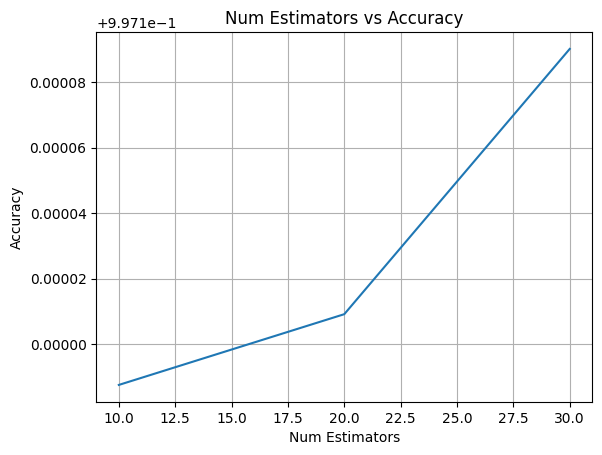

In [38]:
plot(est_params, est_scores, "Num Estimators Vs Accuracy", "Num Estimators", "Accuracy")

#### Num Estimators Explaination

Because running larger number  of estimators was taking so long and crashing the kernel, I used 10, 20, and 30 as my number of estimators for plotting. An estimator creates its own tree for estimation, therefore it will require a whole new tree for memory. In the case there are more features, more estimators is preferred. From the plot you can see that the increase in estimators creates an increase in accuracy. 

### Max Depth

In [39]:
depth_scores = []
depth_params = [5, 10, 15]
for depth in depth_params:
    random_forest_model = RandomForestClassifier(max_depth=depth)
    random_forest_model.fit(feature_train, label_train)
    depth_scores.append(random_forest_model.score(feature_test, label_test))

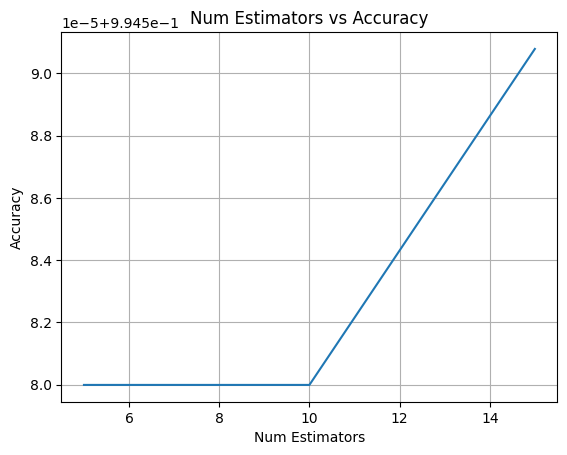

In [40]:
plot(depth_params, depth_scores, "Max Depth Vs Accuracy", 'Max Depth', 'Accuracy')

#### Max Depth Explaination
The max depth does nto affect accuracy until it reaches 10, then it increases. I suspect that it would increase for more estimators beyond what the curve shows but then would taper off and diminishing returns or performance would be reached. Due to how long the models are taking to run, I am limited on time for testing larger depths

### Max Features

In [42]:
feature_scores = []
features_params = ['sqrt', 'log2', None]
for max_feature in features_params:
    random_forest_model = RandomForestClassifier(max_features=max_feature)
    random_forest_model.fit(feature_train, label_train)
    feature_scores.append(random_forest_model.score(feature_test, label_test))

In [ ]:
plot(features_params, feature_scores, "Max Feature vs Accuracy", 'Max Feature', 'Accuracy')

Max features ran for an hour an a half before I cancelled. Taking too long and if it crashes my notebook I don't want to have to rerun everything else.

#### Final Remarks

Given all the results, I would use 30 estimators with a max depth of 15. Depending on resources and more extensive testing, I may increase those values until diminishing returns are reached.